# find top k most indicative icc in all different mcm and show them the same test imagesy

In [2]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns

import sklearn

In [3]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/0_classifier/paper_plots/../src/plot.py'>

In [4]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/0_classifier/paper_plots/../src/paper_utils.py'>

In [6]:
sample_sizes = [10, 100, 500,1000, 2000, 3000,4000,5000]
sample_sizes = [500]
counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, letter="", path_format="../Output/sample_sizes")
test_mcms, test_probs = utils.get_complete_testprobs(mcms_samplesizes,counts_samplesizes,sample_sizes,n_runs=2,smooth=True)

In [7]:
# can always only do distance between two
# probably want distance own vs other
# the mcm that maximises the distance is the one that is selected in the classifier

In [119]:
# select a digit that is the "test image", the one that is shown to all
# select the most indicative icc for own vs a test image of that category
# NOTE: in real life we do not know what category the test image is from
# cannot take most indicative icc
all_byk = []
sample_idx = 0
run_idx = 0
test_digit = 0 # we show a 0 to all mcm and see who has highest reponse
# mcms_range = range(10)
mcms_range = [0,1]
for mcm_idx in mcms_range:
    digit_pair = [mcm_idx,test_digit] # own vs test digit
    _, icc_data,dists = utils.distmap_from_testprobs(test_probs, test_mcms, digit_pair, mcm_idx, sample_idx,run_idx, return_iccdata=True,return_dists=True)
    ord_distidcs = np.argsort(dists)[::-1]
    by_k = np.cumprod(icc_data[ord_distidcs],axis=0)[:,:,digit_pair]
    all_byk.append(by_k)

In [120]:
data_max = np.max([np.max(all_byk[i]) for i in range(len(all_byk))])
data_min = np.min([np.min(all_byk[i]) for i in range(len(all_byk))])

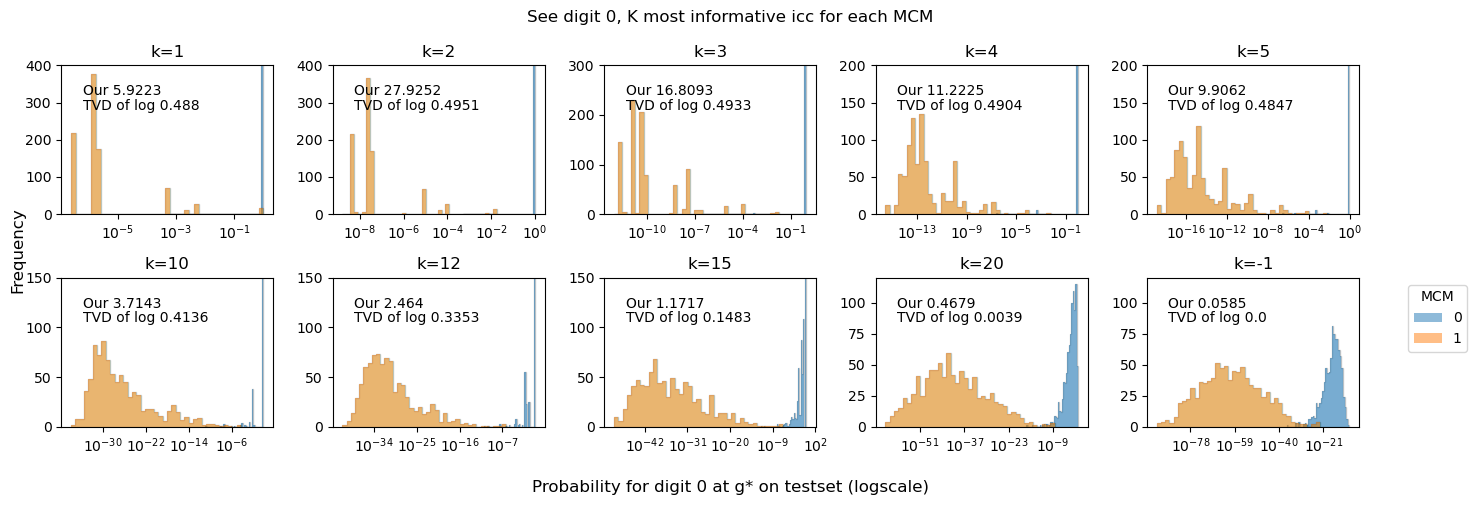

In [121]:
# take say top 5, 3 , 1 in subplots
# k = 3 e.g.,
# take top 3 k for every icc and plot histogram of test

fig, axs = plt.subplots(2,5,figsize=(15,5))
axs = axs.ravel()
# logbins = np.geomspace(data_min,data_max, 40)
top_ks = [1,2,3,4,5,
          10,12,15,20,-1]
colors = myplot.get_list_fromcmap("tab10", N=10)
ylims = [400,400,300,200,200,150,150,150,120,120]
for j, k in enumerate(top_ks):
    ax = axs[j]
    for i,mcm_byk in enumerate(all_byk): # for each mcm, this is the probability distribution for seeing that mcm. mcms are defined by mcm range
        dat = mcm_byk[k,:,1] # test digit
        logbins = np.geomspace(dat.min(),dat.max(), 40)
        ax.hist(dat,bins=logbins, alpha=.2,edgecolor="black",histtype= "stepfilled") # own digit is i, other is -1
        ax.hist(dat,bins=logbins,alpha=.5,histtype= "stepfilled",facecolor=colors[mcms_range[i]],label=mcms_range[i])
        ax.set_ylim((0,ylims[j]))

    # note, this distance is only valid if there are only 2 values in the mcm range
    if len(mcms_range) == 2:
        ax.text(.1,.8,f"Our {utils.norm_distribution_distance(all_byk[0][k,:,1],all_byk[1][k,:,1]).round(4)}", transform=ax.transAxes) # distance mcm1 see test digit, mcm 2 see test digit
        ax.text(.1,.7,f"TVD of log {utils.total_variation_distance(all_byk[0][k,:,1],all_byk[1][k,:,1]).round(4)}", transform=ax.transAxes)

    ax.set_xscale("log")
    ax.set_title(f"k={k}")


fig.supxlabel(f"Probability for digit {test_digit} at g* on testset (logscale)")
fig.supylabel(f"Frequency")

supylabel = fig.supylabel('Frequency')
plt.legend(title="MCM", bbox_to_anchor=(1.2,1,0,0))
fig.suptitle(f"See digit {test_digit}, K most informative icc for each MCM")
fig.tight_layout()
#  color=colors[i]


/var/folders/z9/j9843dsj2t5dsl2bv81xcwww0000gn/T/ipykernel_76889/131015507.py:18: RuntimeWarning: divide by zero encountered in log
  axs[1].plot(x_range, np.log(tvds), label="log(TVD)", color="lightgreen",alpha=.8, marker=".")


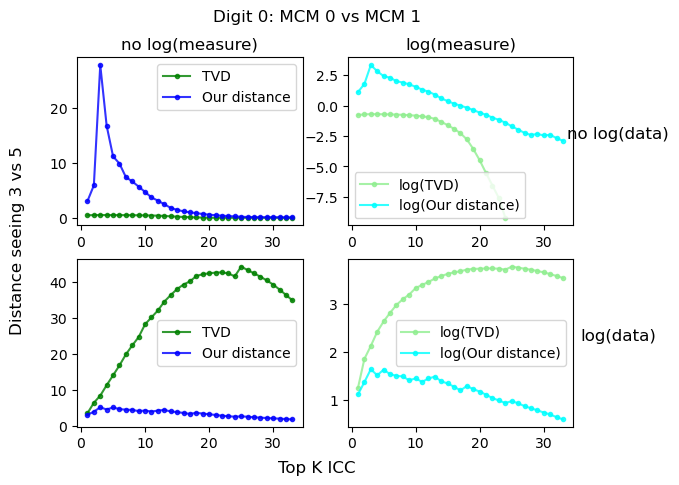

In [123]:
if len(mcms_range) != 2:
    raise ValueError("More than 2 mcms, cannot compute binary distance.")
# distances over k
fig, axs = plt.subplots(2,2)
axs = np.ravel(axs)


minmax_k = np.min([np.max(mbyk.shape[0]) for mbyk in all_byk]) # k are different for the 2 mcm
inp = [i.copy() for i in all_byk]
tvds = np.array([utils.total_variation_distance(inp[0][k,:,1],inp[1][k,:,1]).round(4) for k in range(minmax_k)])
norm_dists = np.array([utils.norm_distribution_distance(inp[0][k,:,1],inp[1][k,:,1]) for k in range(minmax_k)])
x_range = np.arange(1,minmax_k+1)

axs[0].plot(x_range,tvds, label="TVD", color="green",alpha=.8, marker=".")     
axs[0].plot(x_range,norm_dists, label="Our distance", color="blue",alpha=.8, marker=".")
axs[0].legend()
axs[0].set_title("no log(measure)")
axs[1].plot(x_range, np.log(tvds), label="log(TVD)", color="lightgreen",alpha=.8, marker=".")
axs[1].plot(x_range, np.log(norm_dists), label="log(Our distance)",color="cyan",alpha=.8, marker=".")
axs[1].legend()
axs[1].set_title("log(measure)")


inp = [np.log(i) for i in inp]
tvds = np.array([utils.total_variation_distance(inp[0][k,:,1],inp[1][k,:,1]).round(4) for k in range(minmax_k)])
norm_dists = np.array([utils.norm_distribution_distance(inp[0][k,:,1],inp[1][k,:,1]) for k in range(minmax_k)])

axs[2].plot(x_range, tvds, label="TVD", color="green",alpha=.8, marker=".")     
axs[2].plot(x_range, norm_dists, label="Our distance", color="blue",alpha=.8, marker=".")
axs[2].legend()
axs[3].plot(x_range, np.log(tvds), label="log(TVD)", color="lightgreen",alpha=.8, marker=".")
axs[3].plot(x_range, np.log(norm_dists), label="log(Our distance)",color="cyan",alpha=.8, marker=".")
axs[3].legend()


axs[1].set_ylabel("no log(data)", rotation=0, size='large')
axs[1].yaxis.set_label_coords(1.2,.5)
axs[3].set_ylabel("log(data)", rotation=0, size='large')
axs[3].yaxis.set_label_coords(1.2,.5)

fig.suptitle(f"Digit {test_digit}: MCM {mcms_range[0]} vs MCM {mcms_range[1]}")
fig.supxlabel("Top K ICC")
fig.supylabel("Distance seeing 3 vs 5")
# plt.yscale("log")
plt.legend()
